# 数据加载

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# df是一个数据框，调用pandas库中read_csv函数将指定路径下的数据加载到df数据框中
df = pd.read_csv('/Users/yaoyuyang/Desktop/📖校园学习/毕业论文/数据/【日度201912】Foreign_Exchange_Rates.csv')
# 通过下述代码将DataFrame中的数据转为数值类型
# 选取除了Time Series列以外的所有列，第一个为行，第二个为列
selected_columns = df.loc[:, df.columns != 'Time Serie']
# apply函数可以将运算作用到表格内所有数据上，第一个为函数（转化为数值），第二个为转化失败时的操作（此处为不做处理）
selected_columns = selected_columns.apply(pd.to_numeric, errors='coerce')
# update方法会将selected_columns中的值替换到df中对应的位置。
df.update(selected_columns)
df['Time Serie'] = pd.to_datetime(df['Time Serie'])
df['Time Serie']

0      2000-01-03
1      2000-01-04
2      2000-01-05
3      2000-01-06
4      2000-01-07
          ...    
5212   2019-12-25
5213   2019-12-26
5214   2019-12-27
5215   2019-12-30
5216   2019-12-31
Name: Time Serie, Length: 5217, dtype: datetime64[ns]

In [4]:
print(df.dtypes)

Unnamed: 0                                            int64
Time Serie                                   datetime64[ns]
AUSTRALIA - AUSTRALIAN DOLLAR/US$                    object
EURO AREA - EURO/US$                                 object
NEW ZEALAND - NEW ZELAND DOLLAR/US$                  object
UNITED KINGDOM - UNITED KINGDOM POUND/US$            object
BRAZIL - REAL/US$                                    object
CANADA - CANADIAN DOLLAR/US$                         object
CHINA - YUAN/US$                                     object
HONG KONG - HONG KONG DOLLAR/US$                     object
INDIA - INDIAN RUPEE/US$                             object
KOREA - WON/US$                                      object
MEXICO - MEXICAN PESO/US$                            object
SOUTH AFRICA - RAND/US$                              object
SINGAPORE - SINGAPORE DOLLAR/US$                     object
DENMARK - DANISH KRONE/US$                           object
JAPAN - YEN/US$                         

# 数据预处理

In [5]:
# 填充缺失值，先从下往上填充，再从上往下填充
df = df.replace("ND", np.nan)
# backwardfill  forwardfill
df = df.bfill().ffill()

In [6]:
# 先判断数据是否为空，然后进行加总，本质是要找到非空数据的数量
num = df.isnull().sum()
len(df)

5217

In [7]:
print("Total number of days between {} and {} are {}".format(df['Time Serie'].min().date(), df['Time Serie'].max().date(), (df['Time Serie'].max() - df['Time Serie'].min()).days+1))

Total number of days between 2000-01-03 and 2019-12-31 are 7303


In [8]:
# 计算时间范围内的总天数
num_records = (df['Time Serie'].max() - df['Time Serie'].min()).days+1
# 创建完整的时间序列，先建立一个空列表，然后生成一个字典，值为以日为频率的起始和结束日期
data = {}
data["Time Serie"] = pd.date_range(df['Time Serie'].min().date(), df['Time Serie'].max().date(), freq="D")
# 利用pd中的dataframe函数生成一个新的dataframe，数据就是data里的数据
df_full = pd.DataFrame(data=data)
# df_full = df_full.set_index("DATE")
df_full = df_full.merge(df, left_index=True, right_index=True, how="left")
df_full = df_full.bfill().ffill()

In [9]:
df_full.head

<bound method NDFrame.head of      Time Serie_x  Unnamed: 0 Time Serie_y  AUSTRALIA - AUSTRALIAN DOLLAR/US$  \
0      2000-01-03         0.0   2000-01-03                             1.5172   
1      2000-01-04         1.0   2000-01-04                             1.5239   
2      2000-01-05         2.0   2000-01-05                             1.5267   
3      2000-01-06         3.0   2000-01-06                             1.5291   
4      2000-01-07         4.0   2000-01-07                             1.5272   
...           ...         ...          ...                                ...   
7298   2019-12-27      5216.0   2019-12-31                             1.4225   
7299   2019-12-28      5216.0   2019-12-31                             1.4225   
7300   2019-12-29      5216.0   2019-12-31                             1.4225   
7301   2019-12-30      5216.0   2019-12-31                             1.4225   
7302   2019-12-31      5216.0   2019-12-31                             1.4225  

In [10]:
# 计算所有汇率相对于人民币的值
# 首先修改标签，原先是所有货币相对于美元
cols = [col.replace("US$", "YUAN") for col in df.columns]
# 新建关于人民币的dataframe，数据来源是df，标签名称为cols
yuan_df = pd.DataFrame(data = df, columns=cols)
# （iloc用序号如0、1、2，loc用名称如Time series），从第三列开始每列的数据都变为原始数据除以人民币兑美元
yuan_df.iloc[:, 2:] = df.iloc[:, 2:].div(df['CHINA - YUAN/US$'], axis=0)
yuan_df.iloc[:, 2:] = yuan_df.iloc[:, 2:].applymap(lambda x: 1/x)
yuan_df['US$/YUAN'] = df['CHINA - YUAN/US$']
yuan_df.head

<bound method NDFrame.head of       Unnamed: 0 Time Serie  AUSTRALIA - AUSTRALIAN DOLLAR/YUAN  \
0              0 2000-01-03                            5.457290   
1              1 2000-01-04                            5.433362   
2              2 2000-01-05                            5.423331   
3              3 2000-01-06                            5.414754   
4              4 2000-01-07                            5.421294   
...          ...        ...                                 ...   
5212        5212 2019-12-25                            4.853862   
5213        5213 2019-12-26                            4.853862   
5214        5214 2019-12-27                            4.881306   
5215        5215 2019-12-30                            4.893122   
5216        5216 2019-12-31                            4.894060   

      EURO AREA - EURO/YUAN  NEW ZEALAND - NEW ZELAND DOLLAR/YUAN  \
0                  8.408449                              4.350234   
1                  8.535979

In [11]:
# 删除人民币兑人民币
yuan_df = yuan_df.drop(columns = ['CHINA - YUAN/YUAN'])

In [12]:
yuan_df.to_csv('/Users/yaoyuyang/Desktop/📖校园学习/毕业论文/数据/renminbi-exchangerate')

# 数据展示

In [13]:
def scatter_plot(df, country):
    # 遍历 df.columns 中的每个列名 col，并根据条件筛选出符合条件的列名，最终生成一个列表
  selected_col = [col for col in df.columns if country.lower() in col.lower()]
    # 添加时间序列一列
  selected_col.insert(0, 'Time Serie')
    # 选出被需要的两列
  df_show = df[selected_col]
  for index in range(len(selected_col) - 1):
    # plot
    plt.figure(figsize=(18,6))
    # size and color:
    plt.scatter(df_show['Time Serie'], df_show.iloc[:,index + 1])
    plt.title(df_show.columns[index+1], fontsize = 20,fontweight = 'bold', color='blue')
    plt.xlabel("Date", fontsize = 14, fontweight='bold', color='red')
    plt.ylabel('Exchange Rate', fontsize = 14, fontweight='bold', color='red')
    plt.show()

def line_plot(df, country):
    # 遍历 df.columns 中的每个列名 col，并根据条件筛选出符合条件的列名，最终生成一个列表
    selected_col = [col for col in df.columns if country.lower() in col.lower()]
    # 添加时间序列一列
    selected_col.insert(0, 'Time Serie')
    # 选出被需要的两列
    df_show = df[selected_col]
    
    for index in range(len(selected_col) - 1):
        # plot
        plt.figure(figsize=(18, 6))
        # 绘制折线图
        plt.plot(df_show['Time Serie'], df_show.iloc[:, index + 1], linestyle='-')
        plt.title(df_show.columns[index + 1], fontsize=20, fontweight='bold', color='blue')
        plt.xlabel("Date", fontsize=14, fontweight='bold', color='red')
        plt.ylabel('Exchange Rate', fontsize=14, fontweight='bold', color='red')
        plt.xticks(rotation=45)  # 旋转 x 轴标签，避免重叠
        plt.grid(True)  # 添加网格线
        plt.tight_layout()  # 自动调整布局
        plt.show()

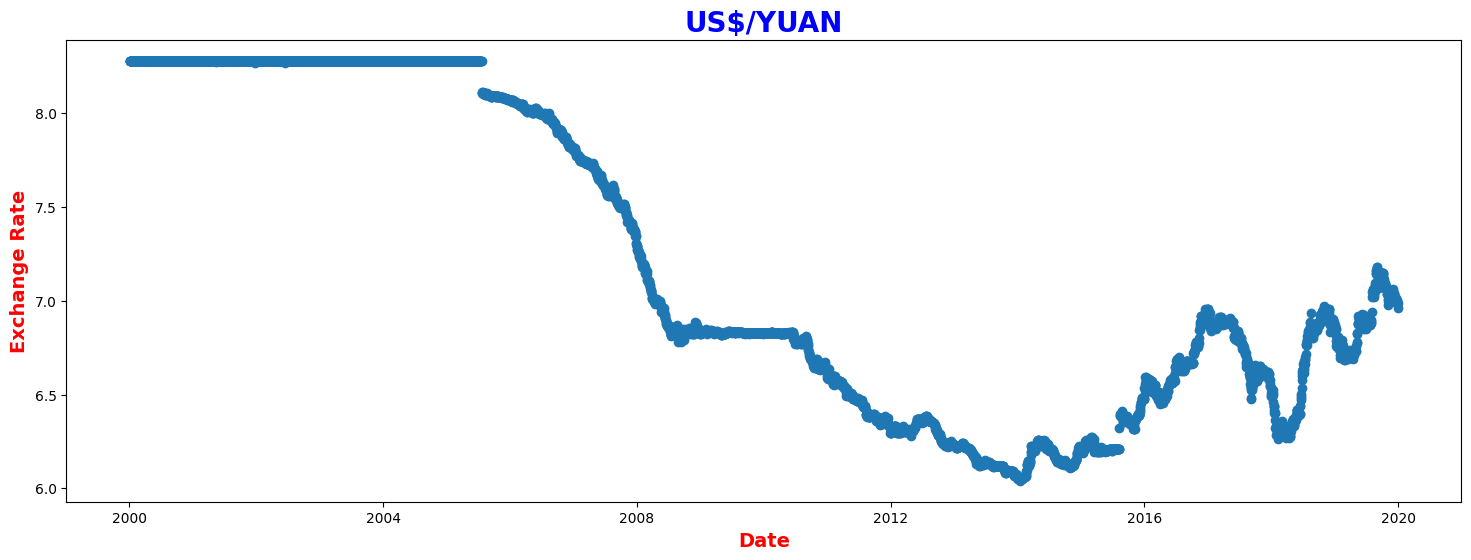

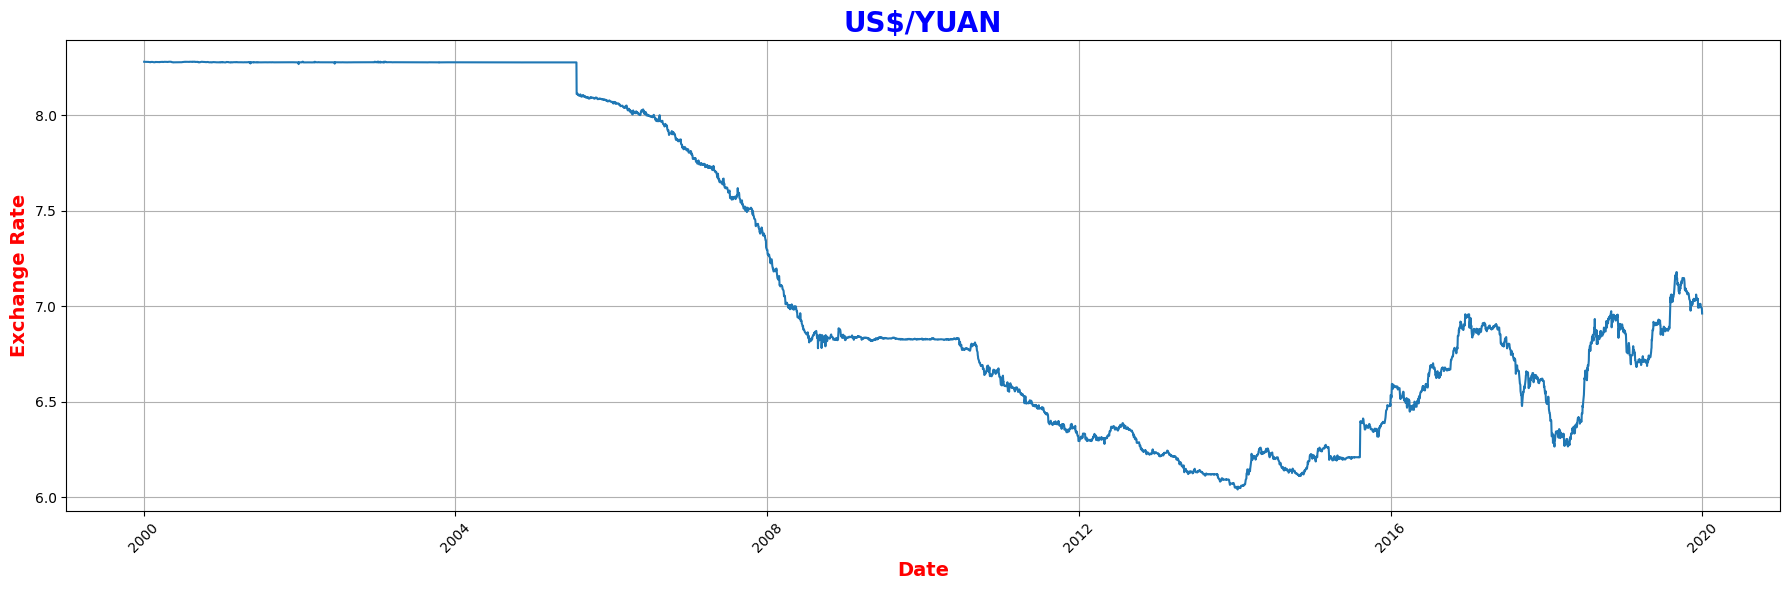

In [14]:
scatter_plot(yuan_df, "US$")
line_plot(yuan_df, "US$")

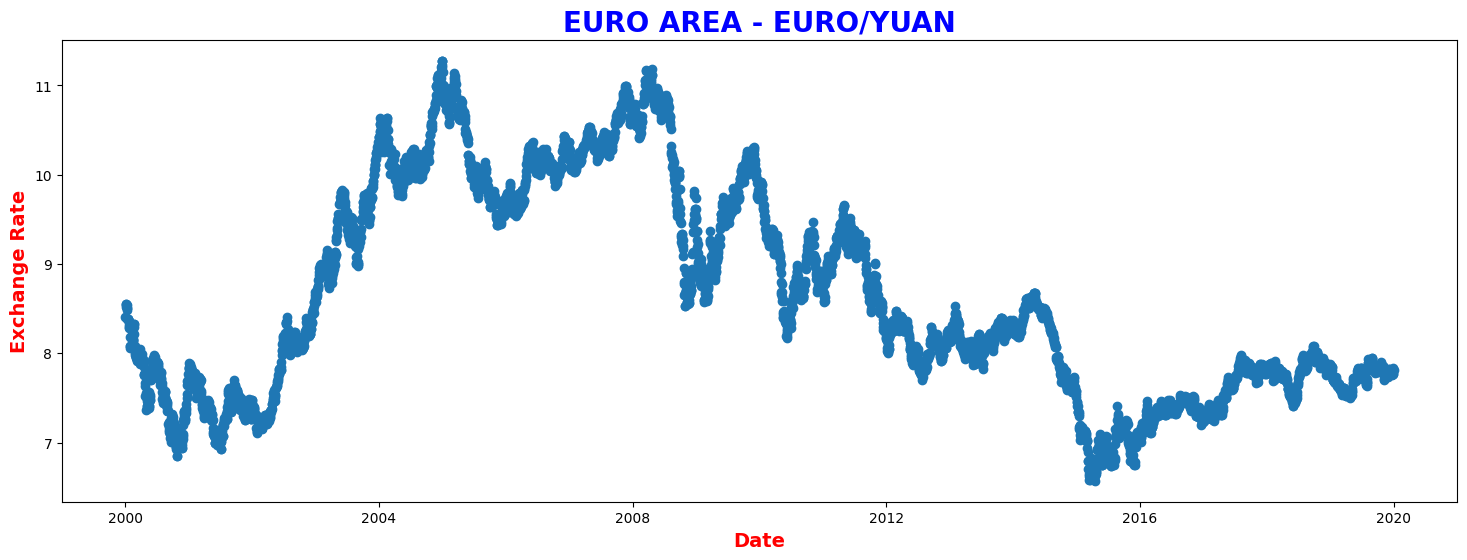

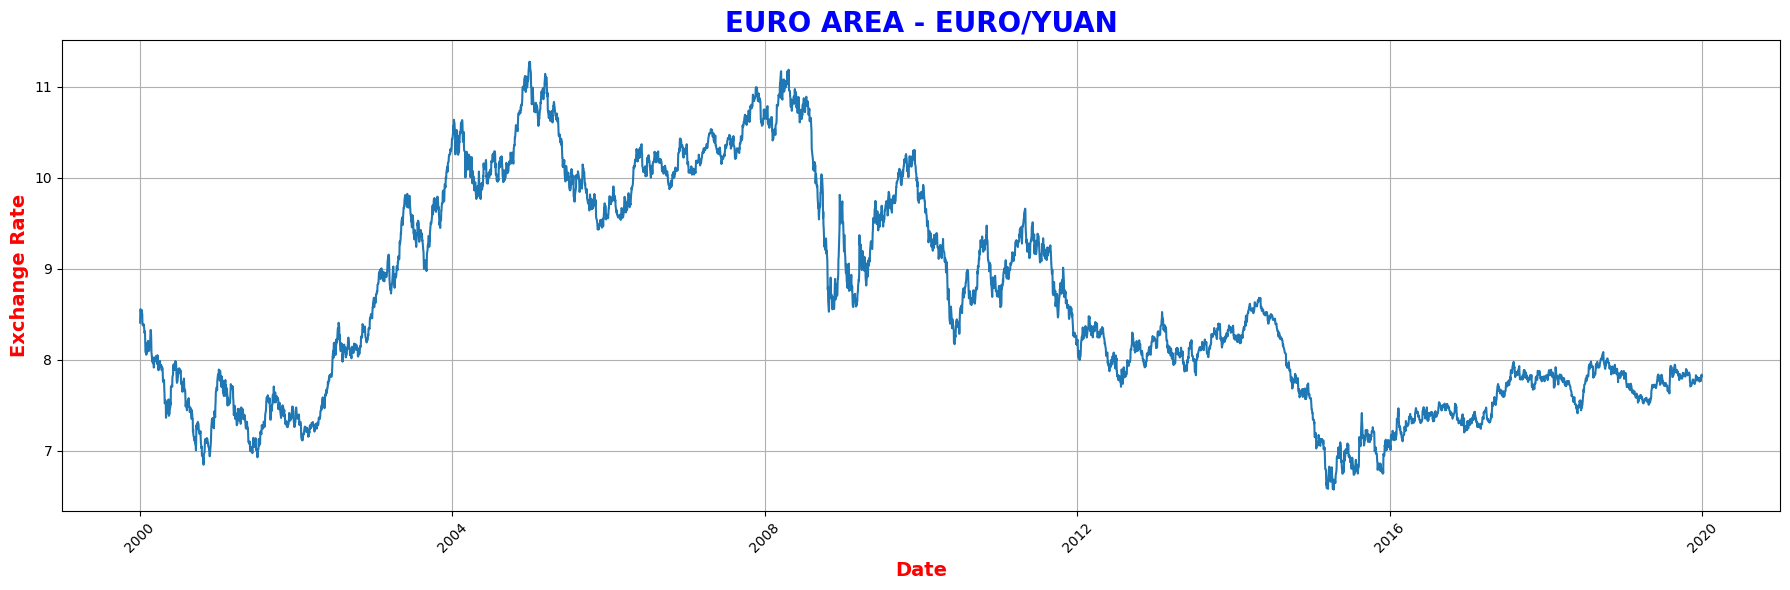

In [15]:
scatter_plot(yuan_df, 'EURO')
line_plot(yuan_df, "EURO")

# 使用LSTM对US$ /YUAN预测

### STEP1 数据准备

In [16]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
#Defining the LSTM model
from keras.models import Sequential
from keras.layers import Dense,LSTM
import torch

In [17]:
# 加载处理后的数据
file_path = '/Users/yaoyuyang/Desktop/📖校园学习/毕业论文/数据/renminbi-exchangerate'
yuan_df = pd.read_csv(file_path, index_col=0)  # 如果第一列是索引，可以使用 index_col=0

In [18]:
# 加载预测数据
us_yuan_data = yuan_df['US$/YUAN'] #get the exchange rate between US and RMB
# 将数据转换为 NumPy 数组，许多机器学习库（如 scikit-learn）要求输入数据是二维数组的形式
# -1 是一个占位符，表示自动计算该维度的大小。这里表示将数组的长度保持不变。
# 1 表示将数组重塑为每行一个值的二维数组。
data = np.array(us_yuan_data).reshape(-1, 1)

In [19]:
# 先定义一个归一化器对象，用于存储归一化所需要的参数。保存训练数据时记得批注掉
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

### STEP2 训练集和测试集拆分

In [20]:
#Training and test sets
# train_size = int(len(data) * 0.8)
# train = data[:train_size]
# test = data[train_size:]
train = data[:4700]
test = data[4700:]

print(train.shape)
print(test.shape)

(4700, 1)
(517, 1)


### STEP3 构造 LSTM 输入输出
- 采用滑动窗口方法构造输入 X 和输出 Y，符合时间序列预测的标准做法。

In [184]:
def get_IO_data(data, input_window, predict_window):
    datax = np.array([data[i:i+input_window, 0] for i in range(len(data)-input_window-predict_window)], dtype=np.float32)
    datay = np.array([data[i+input_window:i+input_window+predict_window, 0] for i in range(len(data)-input_window-predict_window)], dtype=np.float32)
    return datax, datay

In [198]:
input_window = 60
predict_window = 15

train_X, train_Y = get_IO_data(train, input_window=input_window, predict_window=predict_window)
# np.save('./drive/MyDrive/Projects/exchange-rate/data/nor-exr-train-x', train_X)
# np.save('./drive/MyDrive/Projects/exchange-rate/data/nor-exr-train-y', train_Y)
print(train_X.shape)
print(train_Y.shape)
# np.save('/Users/yaoyuyang/Desktop/📖校园学习/毕业论文/数据/yuan-exr-train-x.npy', train_X)
# np.save('/Users/yaoyuyang/Desktop/📖校园学习/毕业论文/数据/yuan-exr-train-y.npy', train_Y)

(4112, 60)
(4112, 1)


In [199]:
test_X, test_Y = get_IO_data(test, input_window=input_window, predict_window=predict_window)
# np.save('./drive/MyDrive/Projects/exchange-rate/data/nor-exr-test-x', test_X)
# np.save('./drive/MyDrive/Projects/exchange-rate/data/nor-exr-test-y', test_Y)
print(test_X.shape)
print(test_Y.shape)
# np.save('/Users/yaoyuyang/Desktop/📖校园学习/毕业论文/数据/yuan-exr-test-x.npy', test_X)
# np.save('/Users/yaoyuyang/Desktop/📖校园学习/毕业论文/数据/yuan-exr-test-y.npy', test_Y)

(983, 60)
(983, 1)


In [200]:
print(test_X[:10])
print(test_Y[:10])

[[0.1953746  0.22037682 0.22037682 0.21506384 0.23002054 0.24662916
  0.24689704 0.2354228  0.23653898 0.23653898 0.24506652 0.24278954
  0.24024467 0.24024467 0.24015537 0.24073578 0.2404679  0.2405572
  0.24162872 0.2397982  0.23850344 0.2388606  0.24002144 0.24078043
  0.23944102 0.23377088 0.23698545 0.23698545 0.23698545 0.23698545
  0.23698545 0.23698545 0.2121618  0.2121618  0.21734083 0.21256362
  0.21430485 0.21408162 0.2170283  0.21823376 0.21957317 0.22269845
  0.22872578 0.2276096  0.22756496 0.219216   0.20814358 0.21220645
  0.20725065 0.20997411 0.20841147 0.20260738 0.20457184 0.21019734
  0.21372443 0.19390124 0.19108848 0.19689257 0.19974998 0.20684883]
 [0.22037682 0.22037682 0.21506384 0.23002054 0.24662916 0.24689704
  0.2354228  0.23653898 0.23653898 0.24506652 0.24278954 0.24024467
  0.24024467 0.24015537 0.24073578 0.2404679  0.2405572  0.24162872
  0.2397982  0.23850344 0.2388606  0.24002144 0.24078043 0.23944102
  0.23377088 0.23698545 0.23698545 0.23698545 0.

### STEP4 调整 LSTM 输入格式

In [201]:
#Processing train and test sets for LSTM model
num_feature = 1
# LSTM（长短期记忆网络）：用于处理时间序列数据，输入数据的形状通常为 (n_samples, n_timesteps, n_features)。
train_X = train_X.reshape(train_X.shape[0],train_X.shape[1], num_feature)
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1], num_feature)
print(train_X.shape)
print(test_X.shape)

(4112, 60, 1)
(983, 60, 1)


### STEP5 搭建 LSTM 模型

In [202]:
model=Sequential()
model.add(LSTM(100,activation='relu',input_shape=(input_window, num_feature)))
model.add(Dense(predict_window))

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [203]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

In [204]:
model.compile(optimizer='adam', loss = 'mse')

### STEP6 训练 LSTM

In [205]:
#Training
model.fit(train_X,train_Y, epochs = 20, batch_size=32)

Epoch 1/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0834
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 6.0342e-05
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 4.3837e-05
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 3.4733e-05
Epoch 5/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 3.6984e-05
Epoch 6/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 3.7976e-05
Epoch 7/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 3.6229e-05
Epoch 8/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 4.3904e-05
Epoch 9/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 3.5323e-05
Epoch 10/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 3.4336e-05
Epoch 11/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 3.1636e-05
Epoch 12/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 4.2041e-05
Epoch 13/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 3.0219e-05
Epoch 14/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 3.

### STEP7 预测与反归一化

In [206]:
pred_Y = model.predict(test_X)
pred_Y = scaler.inverse_transform(pred_Y) #inverse scaler

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [207]:
#Processing test shape
test_Y = np.array(test_Y).reshape(-1,predict_window)
test_Y = scaler.inverse_transform(test_Y)
test_Y.shape

(983, 1)

In [208]:
print(test_Y[:10])

[[6.5124   ]
 [6.5131   ]
 [6.5051003]
 [6.5063   ]
 [6.4648   ]
 [6.448    ]
 [6.4775996]
 [6.4775996]
 [6.476    ]
 [6.4779997]]


### STEP8 可视化

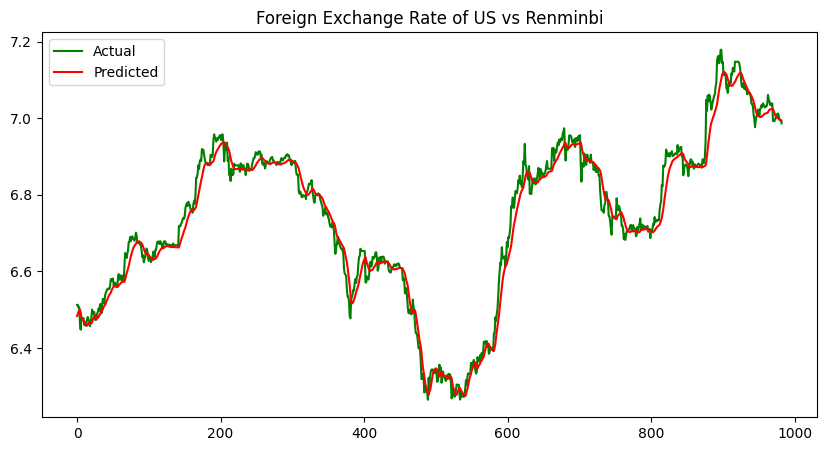

In [209]:
#Visualizing the results
plt.figure(figsize=(10,5))
plt.title('Foreign Exchange Rate of US vs Renminbi')
plt.plot(test_Y , label = 'Actual', color = 'g')
plt.plot(pred_Y , label = 'Predicted', color = 'r')
plt.legend()

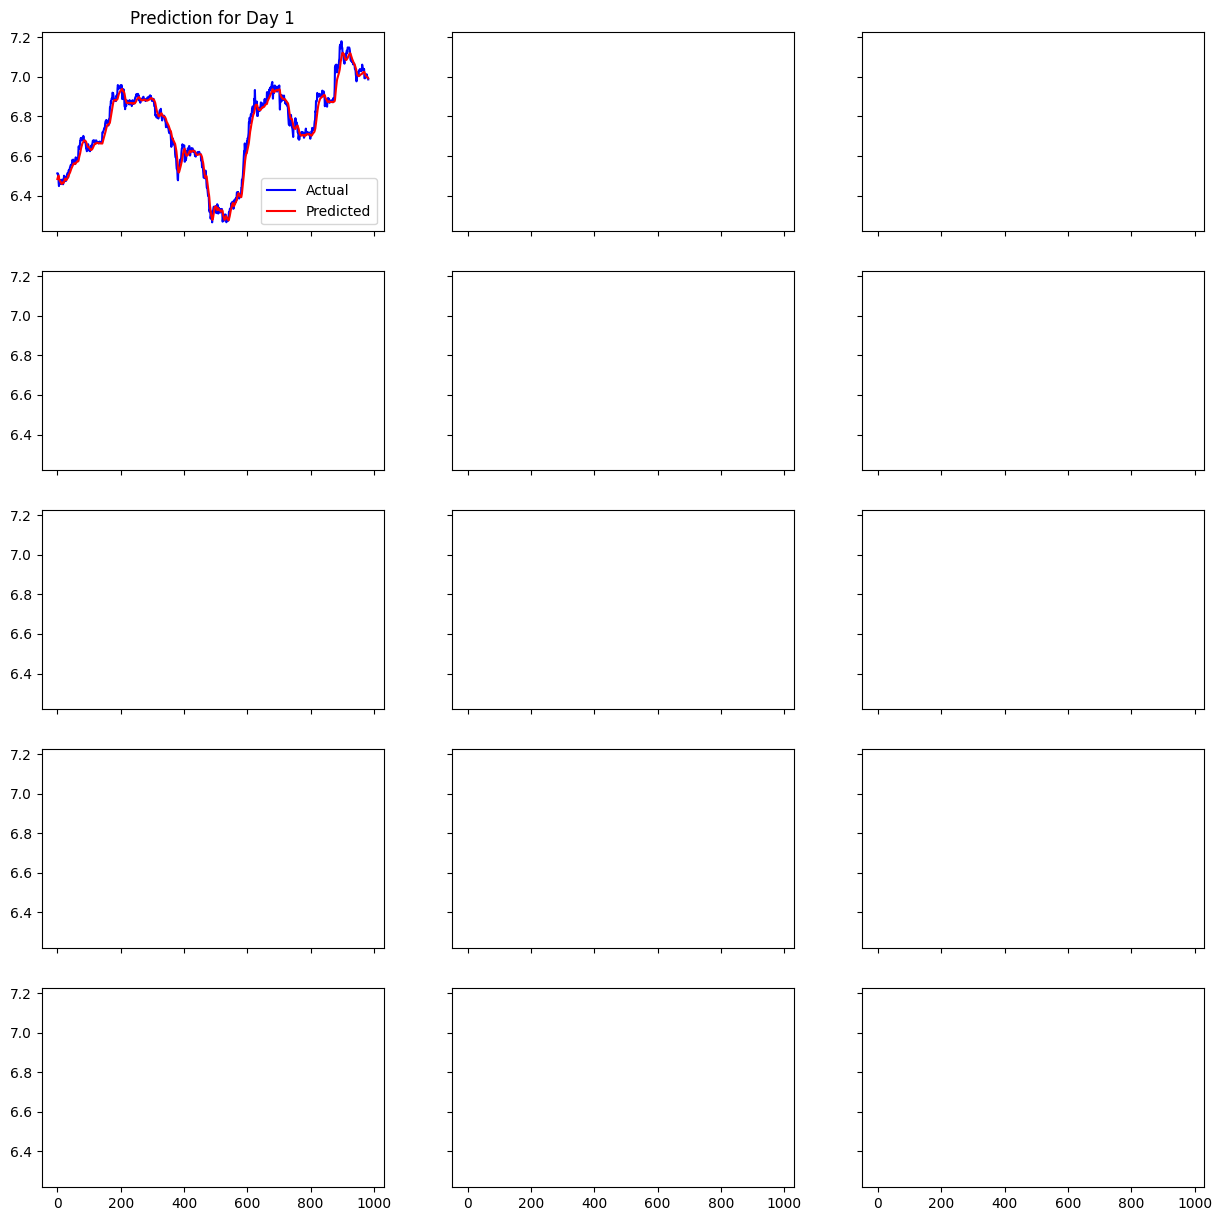

In [210]:
#Visualizing each day prediction results
# plt.figure(figsize=(30,25))
# plt.title('Foreign Exchange Rate of US vs Norway')

fig, axs = plt.subplots(5, 3, sharex='all', sharey='all', figsize=(15,15))

for i in range(predict_window):
  axs[i//3, i%3].plot(test_Y[:, i] , label = 'Actual', color = 'b')
  axs[i//3, i%3].plot(pred_Y[:, i] , label = 'Predicted', color = 'r')
  axs[i//3, i%3].title.set_text(f"Prediction for Day {i+1}")
  axs[i//3, i%3].legend()

In [211]:
#Visualizing 15 test data for next 15 days prediction results

num_testdata = test_Y.shape[0] // predict_window
num_row = num_testdata // 3
fig, axs = plt.subplots(num_row, 3, sharex='all', sharey='all', figsize=(15,15))
plt.subplots_adjust(hspace=0.5)

for i in range(num_row * 3):
  axs[i//3, i%3].plot(test_Y[predict_window * i, :] , label = 'Actual', color = 'g')
  axs[i//3, i%3].plot(pred_Y[predict_window * i, :] , label = 'Predicted', color = 'r')
  axs[i//3, i%3].title.set_text(f"Test Data {i+1}: 15-day Prediction")
  axs[i//3, i%3].legend()

Error in callback <function _draw_all_if_interactive at 0x31073ba60> (for post_execute):
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/IPython/core/events.py", line 89, in trigger
    func(*args, **kwargs)
  File "/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/matplotlib/pyplot.py", line 197, in _draw_all_if_interactive
    draw_all()
  File "/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/matplotlib/_pylab_helpers.py", line 132, in draw_all
    manager.canvas.draw_idle()
  File "/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/matplotlib/backend_bases.py", line 1893, in draw_idle
    self.draw(*args, **kwargs)
  File "/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/matplotlib/backends/backend_agg.py", line 388, in draw
    self.figure.draw(self.renderer)
  File "/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/matplotlib/artist.py", line 95, in draw_wrapper
    result = draw(artist, renderer, *args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/yaoyu

Error in callback <function flush_figures at 0x31ab12020> (for post_execute):


KeyboardInterrupt: 

In [217]:
test_Y

array([[6.5124   ],
       [6.5131   ],
       [6.5051003],
       [6.5063   ],
       [6.4648   ],
       [6.448    ],
       [6.4775996],
       [6.4775996],
       [6.476    ],
       [6.4779997],
       [6.4599   ],
       [6.4628   ],
       [6.458    ],
       [6.4638996],
       [6.4768   ],
       [6.481    ],
       [6.4729996],
       [6.4717   ],
       [6.4571004],
       [6.4675   ],
       [6.481    ],
       [6.5004   ],
       [6.4900002],
       [6.4905   ],
       [6.494    ],
       [6.4735003],
       [6.4737997],
       [6.4737997],
       [6.4900002],
       [6.4945   ],
       [6.5032   ],
       [6.4969997],
       [6.514    ],
       [6.5150003],
       [6.491    ],
       [6.514    ],
       [6.5285   ],
       [6.5183997],
       [6.517    ],
       [6.5369997],
       [6.544    ],
       [6.5484996],
       [6.5533   ],
       [6.5552   ],
       [6.5537996],
       [6.554    ],
       [6.5615   ],
       [6.5798   ],
       [6.5798   ],
       [6.5748005],


In [213]:
pred_Y

array([[6.483508 ],
       [6.489155 ],
       [6.4948416],
       [6.4980483],
       [6.5006976],
       [6.492982 ],
       [6.481071 ],
       [6.4767714],
       [6.4737263],
       [6.4714017],
       [6.4704695],
       [6.4660673],
       [6.463021 ],
       [6.4596415],
       [6.4584007],
       [6.460839 ],
       [6.4646034],
       [6.4664235],
       [6.467605 ],
       [6.4650555],
       [6.4647346],
       [6.4675674],
       [6.4747663],
       [6.479011 ],
       [6.4824705],
       [6.4858246],
       [6.4835696],
       [6.480768 ],
       [6.477844 ],
       [6.478862 ],
       [6.481143 ],
       [6.485409 ],
       [6.487928 ],
       [6.4938445],
       [6.4992847],
       [6.4982224],
       [6.5016365],
       [6.5072565],
       [6.510333 ],
       [6.512201 ],
       [6.5169196],
       [6.5218816],
       [6.5266914],
       [6.5313797],
       [6.5355806],
       [6.5389   ],
       [6.5416203],
       [6.5447755],
       [6.5498104],
       [6.554258 ],


In [214]:
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
print((f"Prediction MSE for ALL"))
print(mean_squared_error(test_Y, pred_Y))
for i in range(predict_window):
  print((f"Prediction MSE for Day {i+1}"))
  print(mean_squared_error(test_Y[:, i], pred_Y[:, i]))

Prediction MSE for ALL
0.0010307736
Prediction MSE for Day 1
0.0010307736


In [218]:
print((f"Prediction MAE for ALL"))
print(mean_absolute_error(test_Y, pred_Y))
for i in range(predict_window):
  print((f"Prediction MAE for Day {i+1}"))
  print(mean_absolute_error(test_Y[:, i], pred_Y[:, i]))

Prediction MAE for ALL
0.023264155
Prediction MAE for Day 1
0.023264155


In [219]:
print((f"Prediction r2 for ALL"))
print(r2_score(test_Y, pred_Y))
for i in range(predict_window):
  print((f"Prediction r2 for Day {i+1}"))
  print(r2_score(test_Y[:, i], pred_Y[:, i]))

Prediction r2 for ALL
0.9769558346401196
Prediction r2 for Day 1
0.9769558346401196


# 利用DLinear预测US$/YUAN

In [164]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

#目的：实现滑动平均（Moving Average），用来平滑时间序列，从而提取趋势部分（Trend）

#moving_avg 继承自 torch.nn.Module
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    # 初始化函数，self是一定要有的，其余用于确定调用moving_avg时需要的输入
    # kernel_size：滑动窗口的大小，控制趋势平滑程度。
    # stride：窗口滑动的步长，默认为 1。
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

# 利用 moving_avg 计算滑动平均来提取趋势，然后计算残差得到季节性部分
class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

# 实现DLinear 模型的完整逻辑，包括：
# 调用 series_decomp 进行时间序列分解（趋势 + 季节性）。
# 使用线性层预测趋势和季节性。
# 最终预测结果是趋势 + 季节性的加和。
class PredictionModel(nn.Module):
    """
    Decomposition-Linear
    """
    def __init__(self, configs):
        super(PredictionModel, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.device = configs.device

        # Decompsition Kernel Size
        kernel_size = 25
        self.decompsition = series_decomp(kernel_size)
        self.individual = configs.individual
        self.channels = configs.enc_in

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()

            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))

                # Use this two lines if you want to visualize the weights
                # self.Linear_Seasonal[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
                # self.Linear_Trend[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)

            # Use this two lines if you want to visualize the weights
            # self.Linear_Seasonal.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
            # self.Linear_Trend.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),self.pred_len],dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0,2,1) # to [Batch, Output length, Channel]


In [165]:
from torch.utils.data import IterableDataset
from torch.utils.data import DataLoader
import random
import pandas as pd
import numpy as np
import os

# 定义一个可迭代的数据集类 EXDataset，用于从 .npy 文件中加载数据，并按照批量大小 batch_size 进行切分。
# 它继承了 torch.utils.data.IterableDataset，适用于流式处理大规模数据，而不是一次性加载整个数据集。
class EXDataset(IterableDataset):
    def __init__(self, filepath, batch_size):
        self.filepath = filepath
        self.batch_size = batch_size

    def __iter__(self):
        return self

    def __next__(self):
        data = np.load(self.filepath)
        batches = np.array_split(data, len(data) // self.batch_size)
        for batch in batches:
            yield batch


In [166]:
# 这段代码定义了一个 配置类 Config，用于存储 DLinear 模型的超参数
class Config():

  def __init__(self, seq_len, pred_len, individual, enc_in, device, kernel_size=25):
    self.seq_len = seq_len
    self.pred_len = pred_len
    self.individual = individual
    self.enc_in = enc_in
    self.kernel_size = kernel_size
    self.device = device

  def get_seq_len(self):
    return self.seq_len
  def set_seq_len(self, value):
    self.seq_len = value

  def get_pred_len(self):
      return self.pred_len
  def set_pred_len(self, value):
    self.pred_len = value

  def get_individual(self):
    return self.individual
  def set_individual(self, value):
    self.individual = value

  def get_enc_in(self):
    return self.enc_in
  def set_enc_in(self, value):
    self.enc_in = value

  def get_device(self):
    return self.device
  def set_device(self, value):
    self.device = value

  def get_kernel_size(self):
    return self.kernel_size
  def set_kernel_size(self, value):
    self.kernel_size = value

In [167]:
#DLinear 模型的训练过程
import time
import numpy as np
import tensorflow as tf


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
configs = Config(seq_len=60, pred_len=15, individual=False, enc_in=1, device=device, kernel_size = 7)
model = PredictionModel(configs).to(device)

epochs = 700
batch_size = 32
lr = 0.00005

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

filepath = '/Users/yaoyuyang/Desktop/📖校园学习/毕业论文/数据/'
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
start_time = time.time()
train_loss = []

for epoch in range(epochs):
  train_x = EXDataset(filepath + 'yuan-exr-train-x.npy', batch_size)
  train_y = EXDataset(filepath + 'yuan-exr-train-y.npy', batch_size)
  x_batches = next(iter(train_x))
  y_batches = next(iter(train_y))
  for x, y in zip(x_batches, y_batches):
    x = torch.from_numpy(x.astype(np.float32)).to(device)
    y = torch.from_numpy(y.astype(np.float32)).to(device)
    x = x.reshape(x.shape[0],x.shape[1], model.channels) #(batch, output_len, channel)
    y_pred = model(x)
    y_pred = y_pred.reshape(-1,y_pred.shape[1]) #(batch * channel, output_len)
    assert y_pred.shape == y.shape, f"y_pred shape is not equal to y shape"
    # print(y_pred[:5,:])
    # print(y[:5,:])
    loss = criterion(y_pred, y)
    train_loss.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(f"average train loss: {np.average(train_loss)}")
  train_loss = []

best_model_path = filepath + 'checkpoint.pth'
torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, best_model_path)





average train loss: 39.8049208190706
average train loss: 17.686315271589493
average train loss: 7.103399324748251
average train loss: 2.7213166049785085
average train loss: 1.0060948375612497
average train loss: 0.3560926007727782
average train loss: 0.11937796177032094
average train loss: 0.03849609422549191
average train loss: 0.013230290854052227
average train loss: 0.006158771910931036
average train loss: 0.004406171435322095
average train loss: 0.004021659268902213
average train loss: 0.003944990514254541
average train loss: 0.003929059517910598
average train loss: 0.003923244544542588
average train loss: 0.003917885773060132
average train loss: 0.003910974818205027
average train loss: 0.0039020058202873364
average train loss: 0.00389083988617737
average train loss: 0.0038775050913197142
average train loss: 0.003862085142676127
average train loss: 0.003844773156338811
average train loss: 0.0038258328955230857
average train loss: 0.003805585394426695
average train loss: 0.003784426

average train loss: 0.0027187982486541135
average train loss: 0.0027128221567585976
average train loss: 0.002706872141541478
average train loss: 0.002700953552928493
average train loss: 0.0026950537306776015
average train loss: 0.0026891795046140032
average train loss: 0.0026833283157733
average train loss: 0.00267750446768231
average train loss: 0.0026717011388023414
average train loss: 0.002665930641241074
average train loss: 0.002660172604035122
average train loss: 0.0026544434005397
average train loss: 0.0026487418484116964
average train loss: 0.002643058347985061
average train loss: 0.0026374042293405685
average train loss: 0.002631766930310025
average train loss: 0.0026261547148907186
average train loss: 0.0026205679840182305
average train loss: 0.0026150005912768393
average train loss: 0.0026094592626830287
average train loss: 0.0026039348482400884
average train loss: 0.002598441276151991
average train loss: 0.0025929646765234793
average train loss: 0.002587511043227803
average 

average train loss: 0.001881437960011883
average train loss: 0.0018784432704453341
average train loss: 0.0018754568844643574
average train loss: 0.00187248441862822
average train loss: 0.0018695142385796418
average train loss: 0.0018665550402248402
average train loss: 0.0018636066526040748
average train loss: 0.0018606616640176475
average train loss: 0.0018577318902670312
average train loss: 0.001854809578718333
average train loss: 0.0018518943691358597
average train loss: 0.0018489875469387901
average train loss: 0.0018460902415932247
average train loss: 0.001843199889183072
average train loss: 0.0018403170853515702
average train loss: 0.0018374473179644862
average train loss: 0.0018345836855486494
average train loss: 0.0018317245737257003
average train loss: 0.0018288791170562035
average train loss: 0.0018260400685600568
average train loss: 0.001823211603323216
average train loss: 0.001820389754129792
average train loss: 0.0018175755347884762
average train loss: 0.0018147674602460029

average train loss: 0.0014217872370636542
average train loss: 0.001419980102329848
average train loss: 0.0014181776079138014
average train loss: 0.001416373945984459
average train loss: 0.0014145801890966443
average train loss: 0.0014127881492085079
average train loss: 0.0014110008818180278
average train loss: 0.0014092165961301362
average train loss: 0.0014074339699669104
average train loss: 0.0014056571654287432
average train loss: 0.0014038850142444265
average train loss: 0.0014021161294724355
average train loss: 0.0014003500673298833
average train loss: 0.001398591838033604
average train loss: 0.0013968321849360007
average train loss: 0.0013950779082784316
average train loss: 0.0013933302294617533
average train loss: 0.001391584538813125
average train loss: 0.0013898402580960261
average train loss: 0.0013881003152896988
average train loss: 0.0013863662607541806
average train loss: 0.0013846338372710913
average train loss: 0.0013829060039446024
average train loss: 0.0013811839230331

In [168]:

#Predict
# model.load_state_dict(torch.load(best_model_path)['model_state_dict'])
test_x = EXDataset(filepath+'yuan-exr-test-x.npy', batch_size)
x_batches = next(iter(test_x))
y = np.load(filepath+'yuan-exr-test-y.npy')
y = torch.from_numpy(y.astype(np.float32))

outputs = []
with torch.no_grad():
  for x in x_batches:
    x = torch.from_numpy(x.astype(np.float32)).to(device)
    x = x.reshape(x.shape[0],x.shape[1], model.channels) #(batch, output_len, channel)
    output = model(x).detach().cpu().numpy()
    output = output.reshape(-1,output.shape[1]) #(batch * channel, output_len)
    print(f"output shape:{output.shape}")
    outputs.append(output)

y_pred = tf.concat(outputs, axis=0)
print(y.shape)


output shape:(34, 15)
output shape:(34, 15)
output shape:(34, 15)
output shape:(34, 15)
output shape:(34, 15)
output shape:(34, 15)
output shape:(34, 15)
output shape:(34, 15)
output shape:(34, 15)
output shape:(34, 15)
output shape:(34, 15)
output shape:(34, 15)
output shape:(34, 15)
torch.Size([442, 15])


In [170]:
print(y_pred[:2,])

tf.Tensor(
[[6.302021  6.279962  6.2641144 6.2759356 6.3035564 6.2773666 6.296158
  6.3021574 6.2740293 6.3063207 6.2977285 6.319363  6.2825975 6.2705956
  6.2955823]
 [6.349929  6.2984743 6.27831   6.2873616 6.347407  6.30814   6.326326
  6.3344827 6.30065   6.3372226 6.318735  6.3453536 6.3031945 6.2792425
  6.318463 ]], shape=(2, 15), dtype=float32)


In [171]:
print(y[:2,])

tensor([[6.2785, 6.2881, 6.3045, 6.3045, 6.3045, 6.3035, 6.2798, 6.2655, 6.2876,
         6.2725, 6.2752, 6.2804, 6.2722, 6.2765, 6.2945],
        [6.2881, 6.3045, 6.3045, 6.3045, 6.3035, 6.2798, 6.2655, 6.2876, 6.2725,
         6.2752, 6.2804, 6.2722, 6.2765, 6.2945, 6.3158]])


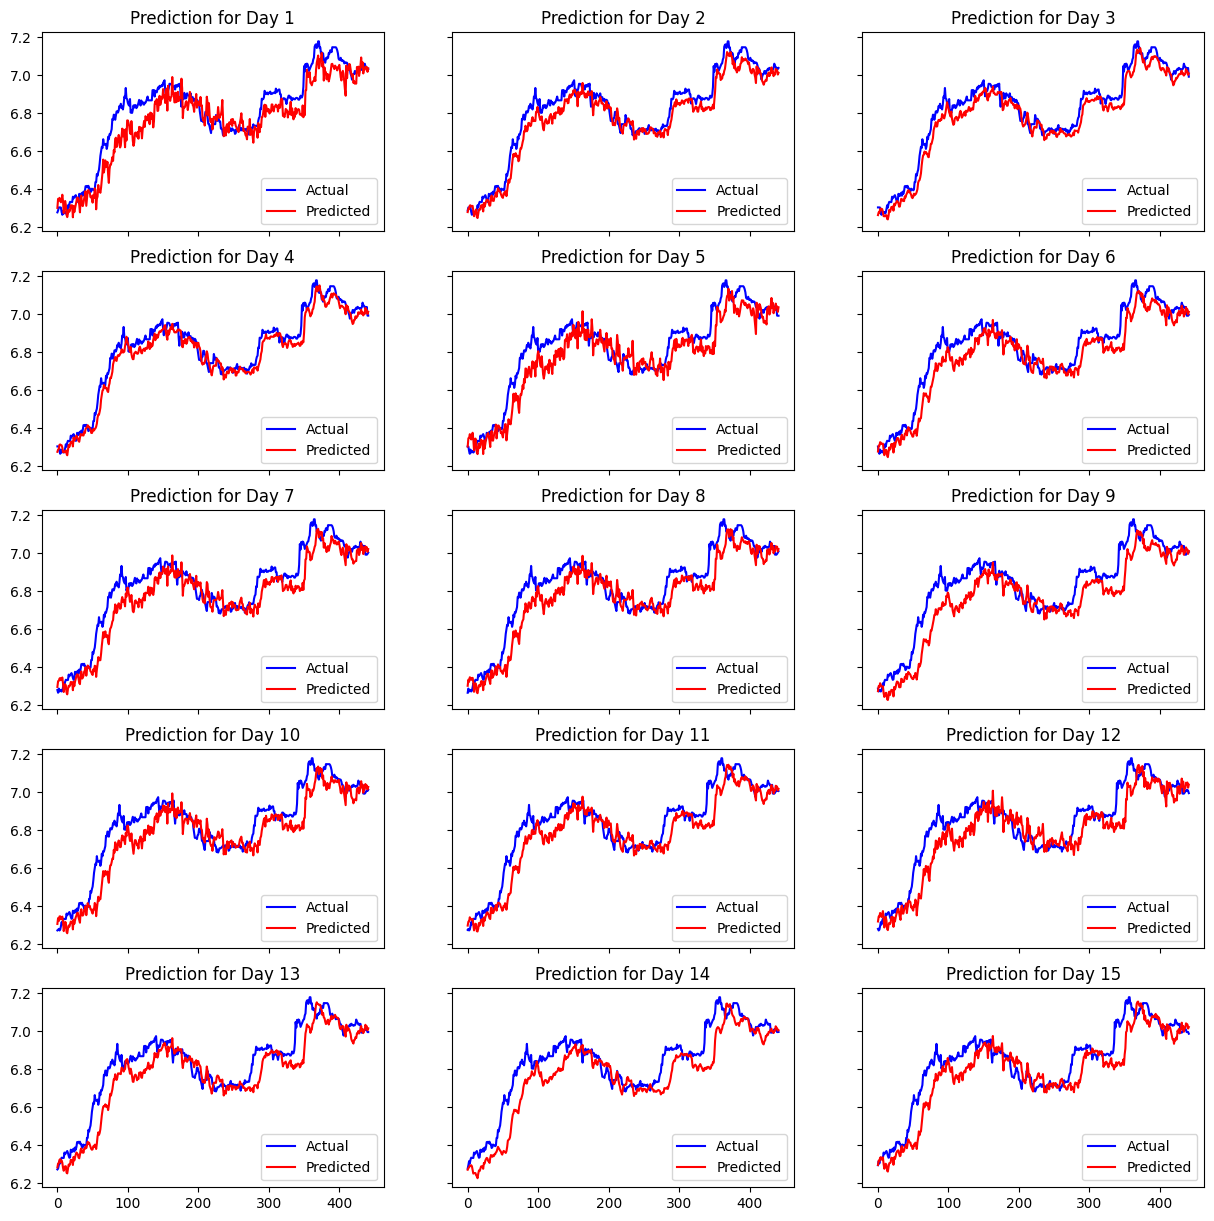

In [172]:
fig, axs = plt.subplots(5, 3, sharex='all', sharey='all', figsize=(15,15))

for i in range(configs.get_pred_len()):
  axs[i//3, i%3].plot(y[:, i] , label = 'Actual', color = 'b')
  axs[i//3, i%3].plot(y_pred[:, i] , label = 'Predicted', color = 'r')
  axs[i//3, i%3].title.set_text(f"Prediction for Day {i+1}")
  axs[i//3, i%3].legend()

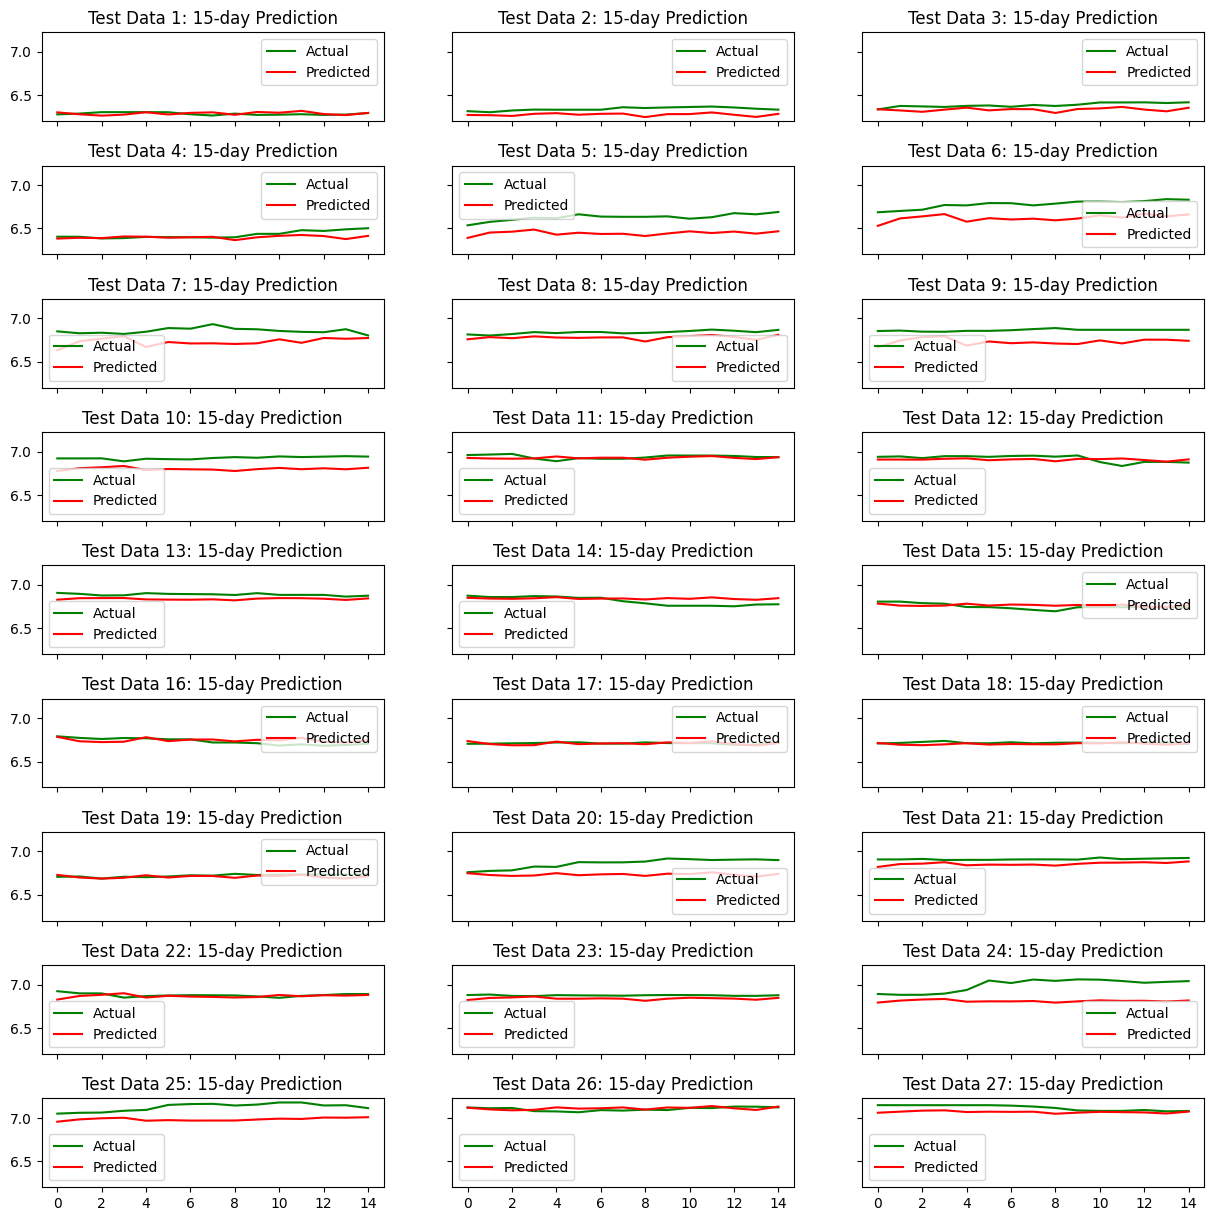

In [173]:
#Visualizing 15 test data for next 15 days prediction results

num_testdata = y.shape[0] // predict_window
num_row = num_testdata // 3
fig, axs = plt.subplots(num_row, 3, sharex='all', sharey='all', figsize=(15,15))
plt.subplots_adjust(hspace=0.5)

for i in range(num_row * 3):
  axs[i//3, i%3].plot(y[predict_window * i, :] , label = 'Actual', color = 'g')
  axs[i//3, i%3].plot(y_pred[predict_window * i, :] , label = 'Predicted', color = 'r')
  axs[i//3, i%3].title.set_text(f"Test Data {i+1}: 15-day Prediction")
  axs[i//3, i%3].legend()

In [174]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print((f"Prediction MSE for ALL"))
print(mean_squared_error(y, y_pred))
for i in range(predict_window):
  print((f"Prediction MSE for Day {i+1}"))
  print(mean_squared_error(y[:, i], y_pred[:, i]))

Prediction MSE for ALL
0.0072581014
Prediction MSE for Day 1
0.008045521
Prediction MSE for Day 2
0.0033418026
Prediction MSE for Day 3
0.002848281
Prediction MSE for Day 4
0.0024160328
Prediction MSE for Day 5
0.0077246577
Prediction MSE for Day 6
0.0060690716
Prediction MSE for Day 7
0.0074055153
Prediction MSE for Day 8
0.0076627755
Prediction MSE for Day 9
0.010440352
Prediction MSE for Day 10
0.008787917
Prediction MSE for Day 11
0.007110937
Prediction MSE for Day 12
0.009126114
Prediction MSE for Day 13
0.008086857
Prediction MSE for Day 14
0.010718136
Prediction MSE for Day 15
0.009087553


In [177]:
print((f"Prediction MAE for ALL"))
print(mean_absolute_error(y, y_pred))
for i in range(predict_window):
  print((f"Prediction MAE for Day {i+1}"))
  print(mean_absolute_error(y[:, i], y_pred[:, i]))

Prediction MAE for ALL
0.064909935
Prediction MAE for Day 1
0.07250247
Prediction MAE for Day 2
0.047765594
Prediction MAE for Day 3
0.044347446
Prediction MAE for Day 4
0.039211005
Prediction MAE for Day 5
0.069344215
Prediction MAE for Day 6
0.06205414
Prediction MAE for Day 7
0.067194
Prediction MAE for Day 8
0.06765664
Prediction MAE for Day 9
0.08090973
Prediction MAE for Day 10
0.07175131
Prediction MAE for Day 11
0.063115515
Prediction MAE for Day 12
0.07242927
Prediction MAE for Day 13
0.066963285
Prediction MAE for Day 14
0.07827325
Prediction MAE for Day 15
0.07013101


In [178]:
print((f"Prediction r2 for ALL"))
print(r2_score(y, y_pred))
for i in range(predict_window):
  print((f"Prediction r2 for Day {i+1}"))
  print(r2_score(y[:, i], y_pred[:, i]))

Prediction r2 for ALL
0.8349619313910452
Prediction r2 for Day 1
0.8346045641769851
Prediction r2 for Day 2
0.9305391879073392
Prediction r2 for Day 3
0.9401029188788735
Prediction r2 for Day 4
0.9486265663667673
Prediction r2 for Day 5
0.8338768483393879
Prediction r2 for Day 6
0.8679750294013173
Prediction r2 for Day 7
0.8370135187173311
Prediction r2 for Day 8
0.8291357530435061
Prediction r2 for Day 9
0.7638671274861889
Prediction r2 for Day 10
0.7986044442501681
Prediction r2 for Day 11
0.8346622321777236
Prediction r2 for Day 12
0.784631555910756
Prediction r2 for Day 13
0.8062937286010609
Prediction r2 for Day 14
0.7391934347602989
Prediction r2 for Day 15
0.7753020636214412
